In [1]:
import os
import platform
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import activations
from keras import regularizers

In [3]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

In [4]:
# check gpu is avaible
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
ranSeed = 66
IMG_SIZE = 224
ColorCh = 3
dataPath = '../../dataset/Fish_Dataset/Fish_Dataset'

In [6]:
os.environ['PYTHONHASHSEED'] = str(ranSeed)
np.random.seed(ranSeed)
tf.random.set_seed(ranSeed)
random.seed(ranSeed)

In [7]:
category = []
for cat in os.listdir(dataPath):
    if not '.' in cat:
        category.append(cat)

print(category)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


In [8]:
train_df1 = pd.read_pickle('../../preprocDF/set1Train.h5')
valid_df1 = pd.read_pickle('../../preprocDF/set1Valid.h5')
train_df2 = pd.read_pickle('../../preprocDF/set2Train.h5')
valid_df2 = pd.read_pickle('../../preprocDF/set2Valid.h5')

train_df = pd.read_pickle('../../preprocDF/train.h5')
valid_df = pd.read_pickle('../../preprocDF/valid.h5')
test_df = pd.read_pickle('../../preprocDF/test.h5')

In [9]:
X_train1 = train_df1.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train1 = train_df1['label']

X_valid1 = valid_df1.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_valid1 = valid_df1['label']

X_train2 = train_df2.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train2 = train_df2['label']

X_valid2 = valid_df2.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_valid2 = valid_df2['label']

X_train = train_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train = train_df['label']

X_valid = valid_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_valid = valid_df['label']

X_test = test_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_test = test_df['label']

In [10]:
# data summary
print('set1 :')
print('{} train images'.format(X_train1.shape[0]))
print('{} valid images'.format(X_valid1.shape[0]))
print('set2 :')
print('{} train images'.format(X_train2.shape[0]))
print('{} valid images'.format(X_valid2.shape[0]))

print('\n{} test images'.format(X_test.shape[0]))

input_shape = X_train1.shape[1:]
print('\ninput shape:', input_shape)

n_classes = len(pd.Series(test_df['label'].values.ravel()).value_counts())
print('\n{} labels count'.format(n_classes))

set1 :
3375 train images
2250 valid images
set2 :
3375 train images
2250 valid images

11250 test images

input shape: (224, 224, 3)

9 labels count


In [11]:
kernel_regularizer = regularizers.l2(0.0001)

In [12]:
def vgg_block(num_convs, num_channels):
    block = tf.keras.models.Sequential()
    
    for _ in range(num_convs):
        block.add(Conv2D(filters=num_channels, kernel_size = (3,3), padding="same"))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        
    block.add(MaxPooling2D(pool_size=2, strides=2))
    return block

def VGG_MODEL():

    conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
 
    vgg_model = Sequential()
    vgg_model.add(Input(shape=input_shape))
    
    for (num_convs, num_channels) in conv_arch:
        vgg_model.add(vgg_block(num_convs, num_channels))
    
    vgg_model.add(Flatten())
    
    vgg_model.add(Dense(units=1024))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Activation('relu'))
    vgg_model.add(Dropout(0.5, seed=ranSeed))
    
    
    vgg_model.add(Dense(units=n_classes, activation='softmax'))
    
    return vgg_model

In [13]:
def print_graph(item, index, history):
    
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    valid_values = history.history['val_' + item][0:index]
    plt.plot(valid_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()


def get_best_epoch(history):
    maxAcc = 0
    maxIdx = -1
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if arr[i] > maxAcc:
                    maxAcc = arr[i]
                    maxIdx = i
    return i
        

def model_summary(model, history):
    
    print('---'*30)

    index = get_best_epoch(history)
    print('Best Epochs: ', index)

    train_accuracy = history.history['accuracy'][index]
    train_loss = history.history['loss'][index]

    val_accuracy = history.history['val_accuracy'][index]
    val_loss = history.history['val_loss'][index]

    print('Accuracy on train:',train_accuracy,'\tLoss on all:',train_loss)
    print('Accuracy on valid:',val_accuracy,'\tLoss on valid:',val_loss)
    print_graph('loss', index, history)
    print_graph('accuracy', index, history)
    print('---'*30)

In [14]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime

EPOCHS = 100
patience = 10
batch_size = 16


def callbackCreate(checkpoint_filepath):
    from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
    import datetime
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get('val_accuracy')>=0.85) & (logs.get('accuracy')>=0.9)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                     mode='min', restore_best_weights=True, 
                                     verbose = 1, min_delta = .00075)

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            verbose = 1,
                                            save_best_only=True)

    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

In [15]:
def CompileModel(model):
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def BuildModel():
    prepared_model = VGG_MODEL()
    compiled_model = CompileModel(prepared_model)
    return compiled_model

def FitModel(model, trainFeature, trainLabel, validFeature, validLabel, callbacks, checkpoint_filepath):

    history = model.fit(trainFeature,trainLabel,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              batch_size = batch_size,
                              validation_data = (validFeature, validLabel)
                              )
    
    for layer in model.layers:
        layer.trainable = True
    
    model.load_weights(checkpoint_filepath)

    final_accuracy_avg = np.mean(history.history["val_accuracy"][-5:])

    final_loss_avg =  np.mean(history.history["val_loss"][-5:])

    #clear_output()
    #model.summary()

    print('\n')
    print('---'*30)
    print('Total Epochs :', len(history.history['loss']))
    print('Last Accuracy on train:',history.history['accuracy'][-1],'\tLast Loss on train:',history.history['loss'][-1])
    print('Last Accuracy on val:', history.history['val_accuracy'][-1] ,'\tLast Loss on val:', history.history['val_loss'][-1])
    print('AVG Accuracy on last 5:', final_accuracy_avg ,'\tAVG Loss on last 5:', final_loss_avg)
    print('---'*30)

    return model, history

In [16]:
compiled_model1 = BuildModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 112, 112, 64)      39232     
_________________________________________________________________
sequential_2 (Sequential)    (None, 56, 56, 128)       222464    
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 256)       1478400   
_________________________________________________________________
sequential_4 (Sequential)    (None, 14, 14, 512)       5905920   
_________________________________________________________________
sequential_5 (Sequential)    (None, 7, 7, 512)         7085568   
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2

In [17]:
time_start = time.time()
checkpoint_filepath = '../../model/Fish_Weight1.h5'
callbacks = callbackCreate(checkpoint_filepath)
model1, history = FitModel(compiled_model1, X_train1, y_train1, X_valid1, y_valid1, callbacks, checkpoint_filepath)
time_end = time.time()



------------------------------------------------------------------------------------------
Total Epochs : 23
Last Accuracy on train: 0.9010370373725891 	Last Loss on train: 0.29755350947380066
Last Accuracy on val: 0.9106666445732117 	Last Loss on val: 0.26378074288368225
AVG Accuracy on last 5: 0.9041777610778808 	AVG Loss on last 5: 0.27708754539489744
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
part 1 time cost 571.1944313049316 s
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Best Epochs:  22
Accuracy on train: 0.9010370373725891 	Loss on all: 0.29755350947380066
Accuracy on valid: 0.9106666445732117 	Loss on valid: 0.26378074288368225


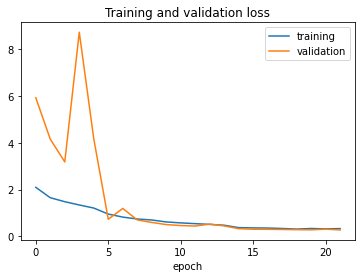

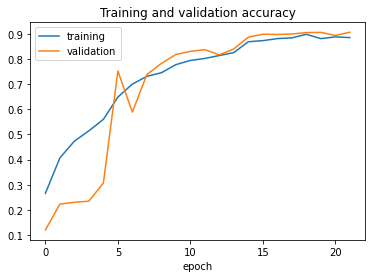

------------------------------------------------------------------------------------------


In [18]:
time_c= time_end - time_start
print('---'*30)
print('part 1 time cost', time_c, 's')
print('---'*30)
model_summary(model1, history)

In [19]:
modelName = '../../model/set1.h5'
model1.save(modelName)

In [20]:
time_start = time.time()
checkpoint_filepath = '../../model/Fish_Weight.h5'
callbacks = callbackCreate(checkpoint_filepath)
for layer in model1.layers[:2]:
    layer.trainable = False
    
model2, history = FitModel(model1, X_train2, y_train2, X_valid2, y_valid2, callbacks, checkpoint_filepath)
time_end = time.time()



------------------------------------------------------------------------------------------
Total Epochs : 15
Last Accuracy on train: 0.9051851630210876 	Last Loss on train: 0.2838080823421478
Last Accuracy on val: 0.941777765750885 	Last Loss on val: 0.18069583177566528
AVG Accuracy on last 5: 0.9386666536331176 	AVG Loss on last 5: 0.18849970102310182
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
part 1+part2 368.79491782188416 s
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Best Epochs:  14
Accuracy on train: 0.9051851630210876 	Loss on all: 0.2838080823421478
Accuracy on valid: 0.941777765750885 	Loss on valid: 0.18069583177566528


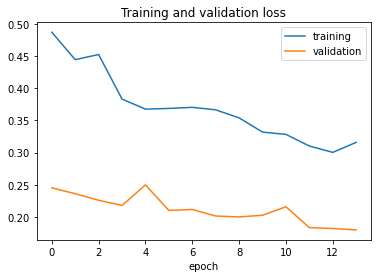

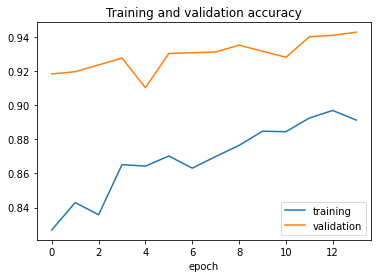

------------------------------------------------------------------------------------------


In [21]:
time_c= time_end - time_start
print('---'*30)
print('part 1+part2', time_c, 's')
print('---'*30)
model_summary(model2, history)

In [22]:
modelName = '../../model/set1set2.h5'
model2.save(modelName)

In [23]:
compiled_model = BuildModel()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 112, 112, 64)      39232     
_________________________________________________________________
sequential_8 (Sequential)    (None, 56, 56, 128)       222464    
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 256)       1478400   
_________________________________________________________________
sequential_10 (Sequential)   (None, 14, 14, 512)       5905920   
_________________________________________________________________
sequential_11 (Sequential)   (None, 7, 7, 512)         7085568   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [24]:
time_start = time.time() 
checkpoint_filepath = '../../model/Fish_Weight.h5'
callbacks = callbackCreate(checkpoint_filepath)
model, history = FitModel(compiled_model, X_train, y_train, X_valid, y_valid, callbacks, checkpoint_filepath)
time_end = time.time()



------------------------------------------------------------------------------------------
Total Epochs : 11
Last Accuracy on train: 0.9139259457588196 	Last Loss on train: 0.2504919767379761
Last Accuracy on val: 0.9408888816833496 	Last Loss on val: 0.17677761614322662
AVG Accuracy on last 5: 0.7673333406448364 	AVG Loss on last 5: 0.9634104877710342
------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------
all train 539.9967634677887 s
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Best Epochs:  10
Accuracy on train: 0.9139259457588196 	Loss on all: 0.2504919767379761
Accuracy on valid: 0.9408888816833496 	Loss on valid: 0.17677761614322662


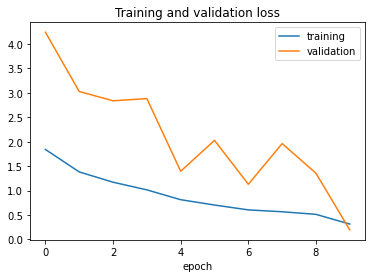

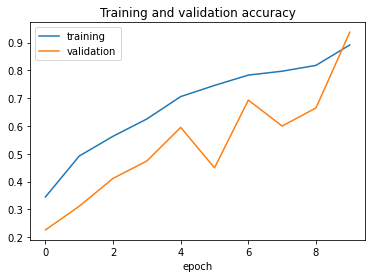

------------------------------------------------------------------------------------------


In [25]:
time_c= time_end - time_start
print('---'*30)
print('all train', time_c, 's')
print('---'*30)
model_summary(model, history)

In [26]:

modelName = '../../model/all.h5'
model.save(modelName)